In [44]:
import mne
from mne.preprocessing import ICA


import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
#import eelbrain as eel

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert

import librosa
import librosa.display
import mido

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *

import pickle


## PREPARING DATA AND STIMULI

Parameters

In [45]:
#subjects_to_process = ['01', '04', '05']
subject = '14'
period = 'post'

with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]
ch_names_72 = ch_names_all[0:72]

fs = 128

Loading EEG data

In [46]:
#directories
eeg_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_eog_ica/{subject}/eeg_eogica_listen_{period}_{subject}.mat'
mTRF_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_mTRF_data'

#LOAD PREPROCESSED DATA
data = loadmat(eeg_path)
eeg = data['eeg']
events_sv = data['events']


### Loading stimuli

Onsets

In [47]:
#loading onset times
events_arr = make_raw_events(events_sv)
events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
onset_indices = events_keystrokes[:,0]

onsets_sv = np.zeros_like(events_sv[0])
onsets_sv[onset_indices] = 1



Surprisal (different types)

In [48]:

#loading surprisal values from DREX
with open ('listen_surprisal_drex.pkl', 'rb') as f:
    surprisal_drex = pickle.load(f)
surprisal_drex = surprisal_drex.squeeze()


In [49]:
"""idyompy_surprisal = loadmat('idyompy_reps.mat')
surprisal_idyompy_rep4 = idyompy_surprisal['rep4'][0]"""


#replace values of 0 with 0.1
#surprisal_idyompy_rep4 =[x if x > 0.1 else 0.1 for x in surprisal_idyompy_rep4]
                    

"idyompy_surprisal = loadmat('idyompy_reps.mat')\nsurprisal_idyompy_rep4 = idyompy_surprisal['rep4'][0]"

In [50]:
surprise_type = surprisal_drex

#make support vector
index_surprisal = 0
surprisal_sv  = []
for num in onsets_sv:
    if num == 1:
        surprisal_sv.append(surprise_type[index_surprisal])
        index_surprisal += 1
    else:
        surprisal_sv.append(num)
surprisal_sv = np.array(surprisal_sv)



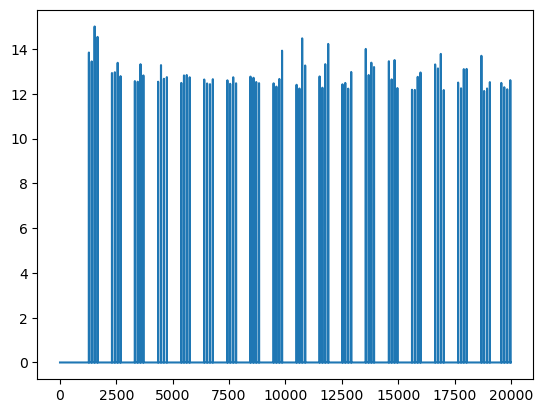

In [52]:
plt.plot(surprisal_sv[0:20000])

In [3]:
arr = np.zeros([1,2,3])
len(arr)

1

## TRAIN TRF

In [89]:
#defining cross-validation segments 
n_segments = 10

eeg_segments = segment(eeg, n_segments)
onset_segments = segment(onsets_sv, n_segments)
surprisal_segments = segment(surprisal_sv, n_segments)


#stacking stimulus segments
AM_sv = np.vstack([onsets_sv, surprisal_sv]).T
AM_segments = segment(AM_sv, n_segments)

#midi_segments = segment(midi_sv, n_segments)
#midi_onsets_segments = segment(midi_onsets_sv, n_segments) #segment not working here because of shape?

In [90]:
#parameters and stimuli

stimulus = AM_segments

#train a baseline model with the onset
fwd_trf_onset = TRF(direction=1)
tmin, tmax =-0.1, 0.3  # range of time lag
#regularization = 1 # regularization parameter lambda, originally 1000
regularizations= [0.0001, 0.01, 1, 100, 10000, 1000000]
r_fwd_onset, lambdas_onset = nested_crossval(fwd_trf_onset, onset_segments, eeg_segments, fs, tmin, tmax, regularizations)


#see if adding other features makes model better
fwd_trf_full = TRF(direction=1)
tmin, tmax =-0.1, 0.3  # range of time lag
#regularization = 1 # regularization parameter lambda, originally 1000
regularizations= [0.0001, 0.01, 1, 100, 10000, 1000000]
r_fwd_full, lambdas_full = nested_crossval(fwd_trf_full, stimulus, eeg_segments, fs, tmin, tmax, regularizations)


Cross-validating[##################################################] 9/9......] 0/6

Cross-validating[##################################################] 9/9......] 1/6

Cross-validating[##################################################] 9/9......] 2/6

Cross-validating[##################################################] 9/9......] 3/6

Cross-validating[##################################################] 9/9......] 4/6

Cross-validating[##################################################] 9/9......] 5/6

Hyperparameter optimization[##################################################] 6/6

Cross-validating[##################################################] 9/9......] 0/6

Cross-validating[##################################################] 9/9......] 1/6

Cross-validating[##################################################] 9/9......] 2/6

Cross-validating[##################################################] 9/9......] 3/6

Cross-validating[################################################

KeyboardInterrupt: 

In [ ]:
r_fwd_onset.mean()

0.14473495803907976

In [ ]:
r_fwd_full.mean()

0.1466608323734266

### Visualization

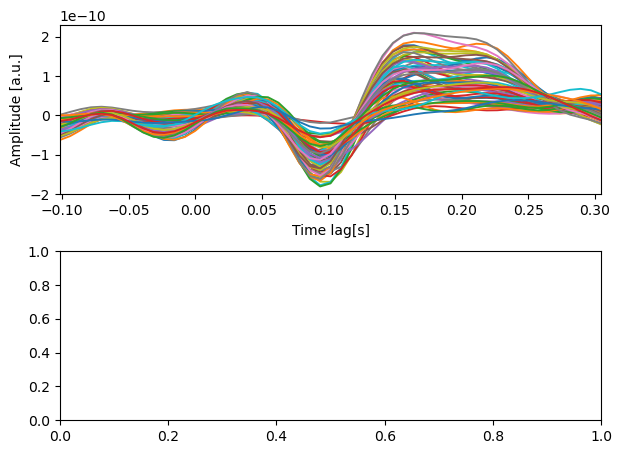

In [ ]:

fig, ax = plt.subplots(2)
plt.tight_layout(pad = 2)
fwd_trf.plot(feature=0, axes=ax[0], show=True)
fwd_trf.plot(feature=1, axes=ax[1], show=True)
#fwd_trf.plot(channel='gfp', axes=ax[0], kind='image', show=False)

plt.show()

In [ ]:
r_fwd

array([0.12833488, 0.1132711 , 0.05484715, 0.06749725, 0.12301336,
       0.07423007, 0.10437597, 0.09048142, 0.09484958, 0.09405183])

In [ ]:
"""from mtrf.stats import crossval
r_fwd = crossval(fwd_trf, stimulus, eeg_segments, fs, tmin, tmax, regularization)
print(f"Mean correlation between actual and predicted response: {r_fwd.mean().round(3)}")
print('Covariance = ', r_fwd**2)"""

Cross-validating[##################################################] 10/10

Mean correlation between actual and predicted response: 0.072
Covariance =  0.00522817274478482


In [ ]:
#savemat(f'{mTRF_path}/listen_{period}_{subject}.mat', {'weights': fwd_trf.weights, 'r': r_fwd})

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


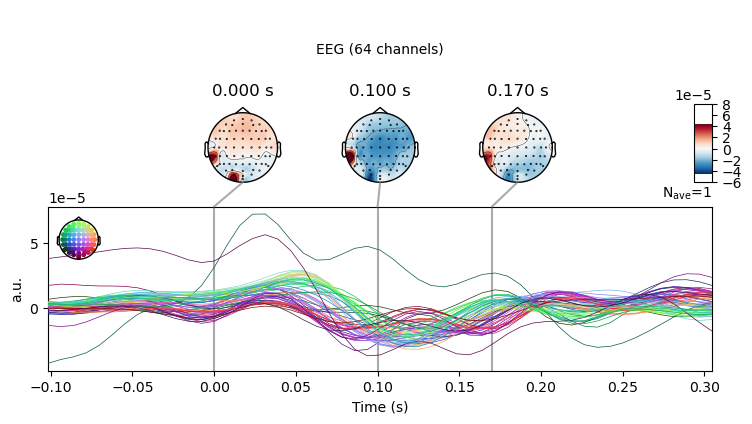

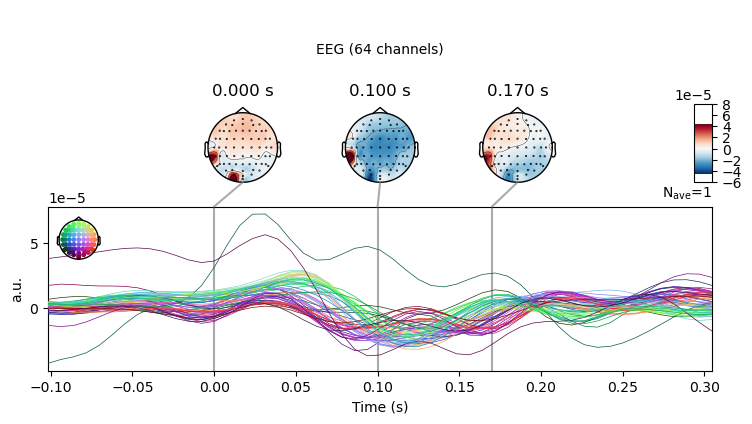

In [ ]:
#display the mTRF kernel in mne butterfly plot

"""from mne.channels import make_standard_montage

# use standard montage for the EEG system used for recording the response
montage = make_standard_montage('biosemi64')
evokeds = fwd_trf.to_mne_evoked(montage)
evokeds[0].plot_joint([0, 0.1, 0.17], topomap_args={"scalings": 1}, ts_args={"units": "a.u.", "scalings": dict(eeg=1)})"""

Save data

## Group statistics (draft)
Reload the .mat data with all the mTRF kernels 

In [94]:
#loading data and concatenating mTRF and r values to master lists with all participants

subjects_to_process = [
                       '01', '02', '04', '05', '06', '07', '08', '09', 
                       '10', '11', '12', '13', '14', '15', '16', '17', '18',
                       '19'
                       ]
#group = 'musicians'


musicians = ['02', '06', '07', '12', '13', '14', '15', '17', '18']

subjects_to_process = musicians

periods = ['pre', 'post']
"""
r_values = {'pre':{'musicians':[], 'nonmusicians':[]}, 'post':{'musicians':[], 'nonmusicians':[]}}
mTRF_kernels = {'pre':{'musicians':[], 'nonmusicians':[]}, 'post':{'musicians':[], 'nonmusicians':[]}}


for subject in subjects_to_process: 
    for period in periods:
        mTRF_data = loadmat(f'{mTRF_path}/listen_{period}_{subject}.mat')
        if subject in musicians:
            r_values[period]['musicians'].append(mTRF_data['r'][0].mean())
        else: 
            r_values[period]['nonmusicians'].append(mTRF_data['r'][0].mean())"""

"\nr_values = {'pre':{'musicians':[], 'nonmusicians':[]}, 'post':{'musicians':[], 'nonmusicians':[]}}\nmTRF_kernels = {'pre':{'musicians':[], 'nonmusicians':[]}, 'post':{'musicians':[], 'nonmusicians':[]}}\n\n\nfor subject in subjects_to_process: \n    for period in periods:\n        mTRF_data = loadmat(f'{mTRF_path}/listen_{period}_{subject}.mat')\n        if subject in musicians:\n            r_values[period]['musicians'].append(mTRF_data['r'][0].mean())\n        else: \n            r_values[period]['nonmusicians'].append(mTRF_data['r'][0].mean())"

In [95]:
#import r values in dataframe form

# Initialize the DataFrame
df = pd.DataFrame(columns=['subject', 'group', 'period', 'mean_r'])

# Iterate over subjects and periods to populate the DataFrame
for subject in subjects_to_process:
    for period in periods:
        # Load the data from the .mat file
        mTRF_data = loadmat(f'{mTRF_path}/listen_{period}_{subject}.mat')
        mTRF_data_surprise = loadmat(f'{mTRF_path}_surprisal/listen_{period}_{subject}.mat')
        
        # Determine the group based on the subject
        if subject in musicians:
            group = 'musicians'
        else:
            group = 'nonmusicians'
        
        # Calculate the mean of 'r' values
        mean_r = mTRF_data['r'][0].mean()
        mean_r_surprise = mTRF_data_surprise['r'][0].mean()
        
        # Append a new row to the DataFrame
        df = df.append({
            'subject': subject,
            'group': group,
            'period': period,
            'mean_r': mean_r,
            'mean_r_surprise': mean_r_surprise
        }, ignore_index=True)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_29970/3838740200.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_29970/3838740200.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_29970/3838740200.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_29970/3838740200.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_2

In [100]:
print('mean r, onset only', df['mean_r'].mean())
print('mean r, onset+surprisal', df['mean_r_surprise'].mean())

mean r, onset only 0.11440284457823689
mean r, onset+surprisal 0.11448523382029399


In [103]:
print('mean r, onset only', df[df['period'] == 'pre']['mean_r'].mean())
print('mean r, onset+surprisal', df[df['period'] == 'pre']['mean_r_surprise'].mean())

mean r, onset only 0.12755287483215125
mean r, onset+surprisal 0.12792631812136004


In [ ]:
from statannotations.Annotator import Annotator

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Define the groups and corresponding colors
groups = ['musicians', 'nonmusicians']
colors = ['steelblue', 'darkgoldenrod']  # Define specific colors for musicians and nonmusicians

# Loop through each group to create subplots
for j, group in enumerate(groups):
    # Subset the DataFrame for the current group
    df_group = df[df['group'] == group]
    
    # Create the plot using Seaborn with a specific color for each group
    sns.lineplot(
        data=df_group,
        x='period',
        y='mean_r',
        hue='subject',
        marker='o',
        ax=axs[j],
        legend=None,
        palette=[colors[j]] * df_group['subject'].nunique()  # Use the same color for all subjects in the group
    )

    # Statistical annotation
    pairs = [('pre', 'post')]
    annotator = Annotator(axs[j], pairs, data=df_group, x='period', y='mean_r')
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    axs[j].set_title(group.capitalize())
    axs[j].set_ylabel('Prediction correlation (r)')
    axs[j].set_xlabel('Training')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [100]:
from scipy.stats import ttest_rel, ttest_1samp, ttest_ind, kstest, wilcoxon
ttest_rel(df[(df['period']=='pre') & (df['group']=='musicians')]['mean_r'], 
          df[(df['period']=='post') & (df['group']=='musicians')]['mean_r'])

TtestResult(statistic=4.454620553586495, pvalue=0.0021262028148250926, df=8)

In [111]:

wilcoxon(df[(df['period']=='pre') & (df['group']== 'musicians')]['mean_r'], 
                df[(df['period']=='post') & (df['group']=='musicians')]['mean_r'])

WilcoxonResult(statistic=0.0, pvalue=0.00390625)

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.io import loadmat

In [ ]:

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for j, group in enumerate(['musicians', 'nonmusicians']):
    ax = axs[j]

    for r in df['r_values']:
        sns.pointplot(data=df[df['group'] == group], x='condition', y='r_values', ax=ax, ci=None)

    # Add annotations
    pairs = [('pre', 'post')]
    annotator = Annotator(ax, pairs, data=df[df['group'] == group], x='condition', y='r_values')
    annotator.configure(test='t-test_paired', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    ax.set_title(group.capitalize())
    ax.set_ylabel('Prediction correlation (r)')
    ax.set_xlabel('Training')

plt.tight_layout()
plt.show()


## A BIG MESS BELOW

Envelope extraction from audio file (extraction of dubious quality)

In [475]:
"""#utils 

#envelope extraction using scipy
def extract_envelope(file, fs = 128):
    sample_rate, data = wavfile.read(file)
    
    # Convert to mono if the audio is stereo
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)
        target_samples = int(len(data) * fs / sample_rate)
        data = scipy.signal.resample(data, target_samples)

    analytic_signal = hilbert(data)
    envelope = np.abs(analytic_signal)
    
    return sample_rate, envelope

def moving_average(signal, window_size):
    """
   """ Smooths a 1D signal using a moving average filter.

    Parameters:
        signal (list or numpy array): The input 1D signal.
        window_size (int): The size of the moving window.

    Returns:
        smoothed_signal (numpy array): The smoothed signal."""
    """

    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")

    # Pad the signal to handle edges
    padding = window_size // 2
    padded_signal = np.pad(signal, (padding, padding), mode='edge')

    # Apply the moving average filter
    weights = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(padded_signal, weights, mode='valid')

    return smoothed_signal

def segment(arr, n_segments):
    segment_size = len(arr) // n_segments  # Calculate the size of each segment
    segments = [arr[i * segment_size : (i + 1) * segment_size] for i in range(10)]  # Slice the array into 10 segments
    return segments
"""

IndentationError: unexpected indent (1349379272.py, line 20)

In [ ]:
#sample_rate, envelope = extract_envelope(stimfile)

In [ ]:
"""#trim eeg to length of env
eeg = eeg[0:envelope.shape[0]]
times = np.linspace(0, eeg.shape[0]/fs, eeg.shape[0])
"""

Text(0, 0.5, 'Envelope (a.u.)')

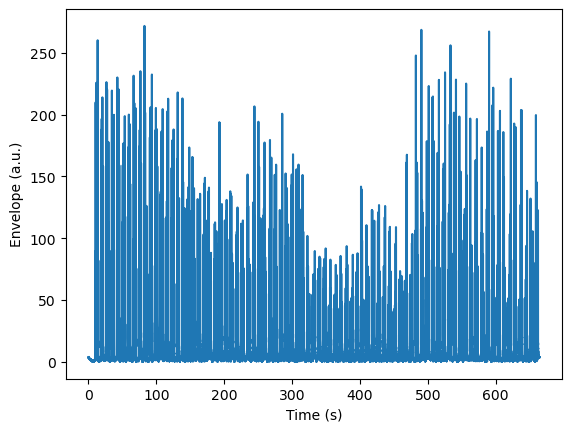

In [ ]:
"""plt.plot(times, envelope)
plt.xlabel('Time (s)')
plt.ylabel('Envelope (a.u.)')"""

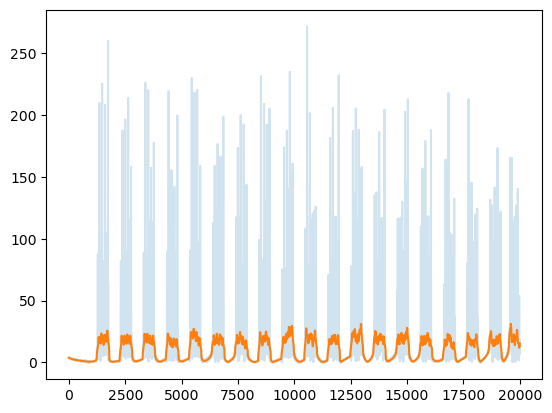

In [ ]:
"""env_smoothed = moving_average(envelope, 101)
plt.plot(envelope[0:20000], alpha = 0.2)
plt.plot(env_smoothed[0:20000])
#plt.ylim(0,10)"""

In [ ]:
"""
env_segments = segment(env_smoothed, 10)
eeg_segments = segment(eeg,10)
"""

In [ ]:
"""n_timepoints = int(env_segments[0].shape[0])
list_noise = []
while len(list_noise) < 10:
    noise = np.random.rand(n_timepoints)*100

    list_noise.append(noise)
list_noise"""

In [ ]:
"""fwd_trf = TRF(direction=1)
tmin, tmax =-0.1, 0.3  # range of time lag
regularization = 1000 # regularization parameter lambda
fwd_trf.train(env_segments, eeg_segments, fs, tmin, tmax, regularization)"""

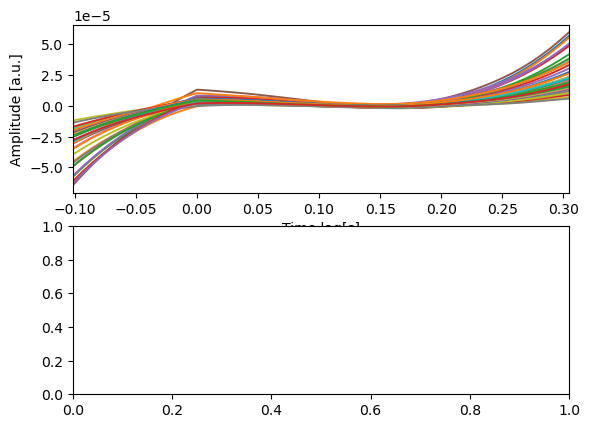

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
fig, ax = plt.subplots(2)
fwd_trf.plot(feature=400, axes=ax[0], show=True)
#fwd_trf.plot(channel='avg', axes=ax[1], kind='image', show=False)
plt.tight_layout()
plt.show()"""

In [ ]:
"""from mtrf.model import load_sample_data

stimulus, response, fs = load_sample_data(n_segments=10, normalize=True)
"""

In [ ]:
"""from mtrf.model import TRF

fwd_trf = TRF(direction=1)
tmin, tmax = 0, 0.4  # range of time lag
regularization = 1000 # regularization parameter lambda
fwd_trf.train(stimulus, response, fs, tmin, tmax, regularization)"""

In [ ]:
"""

# Load the audio file
#file_path = 'your_audio_file.wav'
y, sr = librosa.load(stimfile)

# Perform onset detection
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
"""

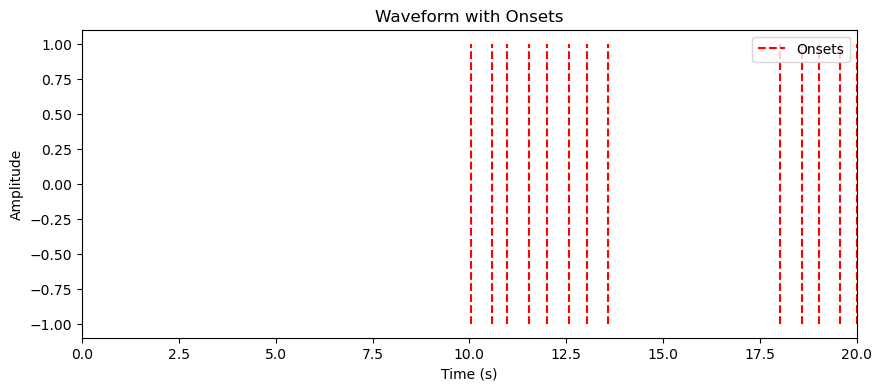

Detected onset times (seconds): [ 10.03102041  10.58829932  10.98303855  11.54031746  12.00471655
  12.56199546  13.02639456  13.58367347  18.01868481  18.57596372
  19.01714286  19.55120181  19.99238095  20.54965986  21.01405896
  21.54811791  25.9599093   26.51718821  26.93514739  27.4924263
  27.91038549  28.4676644   28.90884354  29.46612245  34.01723356
  34.57451247  35.01569161  35.57297052  36.01414966  36.57142857
  37.05904762  37.59310658  42.05133787  42.60861678  42.98013605
  43.53741497  43.9321542   44.46621315  44.9538322   45.51111111
  49.99256236  50.54984127  50.99102041  51.54829932  51.98947846
  52.54675737  52.98793651  53.52199546  58.02666667  58.58394558
  59.00190476  59.55918367  60.04680272  60.58086168  61.02204082
  61.57931973  66.01433107  66.57160998  67.08244898  67.61650794
  68.01124717  68.56852608  68.98648526  69.54376417  74.02521542
  74.58249433  75.00045351  75.55773243  76.02213152  76.57941043
  76.97414966  77.53142857  81.98965986  82.5

In [ ]:
"""# Plot the waveform and onsets
plt.figure(figsize=(10, 4))
#librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(onset_times, -1, 1, color='r', linestyle='--', label='Onsets')
plt.xlabel('Time (s)')
plt.xlim(0,20)
plt.ylabel('Amplitude')
plt.title('Waveform with Onsets')
plt.legend()
plt.show()

# Print detected onset times
print("Detected onset times (seconds):", onset_times)"""

## LIBROSA ONSETS

In [ ]:
"""# Load the audio file
y, sr = librosa.load(stimfile, mono=True)  # Load with original sampling rate and keep stereo if present
target_sr = 128

y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
y_resampled_normalized = librosa.util.normalize(y_resampled)"""

In [ ]:
"""o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, hop_length=25)"""

In [ ]:
"""
onset_times = librosa.onset.onset_detect(y= y, sr=sr, hop_length=40, units='time')
onset_times"""

array([ 10.01723356,  10.56326531,  10.97505669,  11.51927438,
        11.99818594,  12.54421769,  13.01950113,  13.56553288,
        18.00816327,  18.55238095,  18.99863946,  19.5446712 ,
        19.98548753,  20.53151927,  20.98866213,  21.53650794,
        25.95011338,  26.49614512,  26.92426304,  27.47029478,
        27.90385488,  28.44988662,  28.89251701,  29.44036281,
        34.00997732,  34.55600907,  35.00408163,  35.55011338,
        36.00544218,  36.55328798,  37.03401361,  37.58004535,
        42.03537415,  42.57959184,  42.96780045,  43.51564626,
        43.91292517,  44.45895692,  44.93605442,  45.48390023,
        49.98095238,  50.52879819,  50.98231293,  51.53015873,
        51.98185941,  52.52970522,  52.96145125,  53.50748299,
        58.01179138,  58.55782313,  58.98412698,  59.53015873,
        60.02358277,  60.56780045,  61.00861678,  61.55464853,
        66.00090703,  66.54693878,  67.0585034 ,  67.60453515,
        67.99455782,  68.54240363,  68.97414966,  69.51

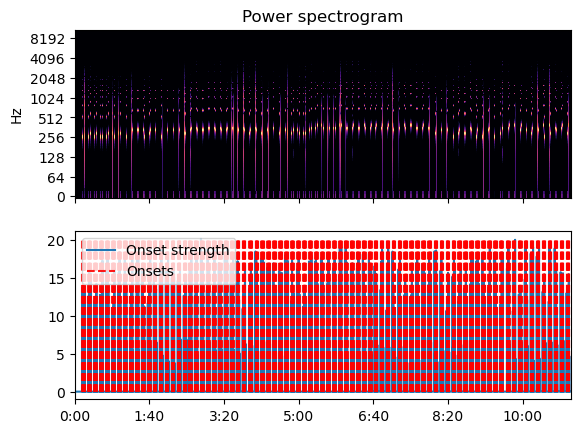

In [ ]:
"""D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()"""

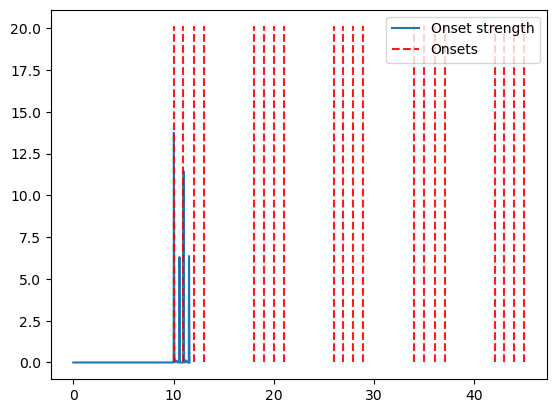

In [ ]:
"""plt.plot(times[0:500], o_env[0:500], label='Onset strength')
plt.vlines(times[onset_frames][0:20], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
plt.legend()"""